In [1]:
import numpy as np
import lightgbm as lgb
import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error 

In [2]:
# train = pd.read_pickle('df_train.pickle')
# test = pd.read_pickle('df_test.pickle')

train = pd.read_csv('df_train_2_extra.csv')
test = pd.read_csv('df_test_2_extra.csv')
#target = np.loadtxt('wang.target.txt')
target=train['target']
outlier=train['outliers']
#outlier = np.zeros(len(target), dtype=np.int)
#outlier[target < -33] = 1

In [3]:
test.shape

(123623, 255)

#### outlier ratio

In [4]:
outlier.sum() / len(outlier)

0.010930233709890698

In [5]:
feats = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]

In [6]:
target_with_outlier = pd.DataFrame({
    'target': target,
    'outlier': outlier
})

In [7]:
test.shape[0]/(train.shape[0]+test.shape[0])

0.379747496467408

In [54]:
len(feats)

253

#### because test/(test+train) = 0.38, we use test_size=0.38

In [8]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats].values, target_with_outlier, test_size=0.38, random_state=12)

In [9]:
X_tr.shape, X_va.shape, y_tr.shape, y_va.shape

((125188, 253), (76729, 253), (125188, 2), (76729, 2))

In [10]:
def get_lb(pred_target):
    return mean_squared_error(y_va.target, pred_target) ** 0.5

### outlier detection

In [11]:
cl_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "scale_pos_weight": 15,
}

In [12]:
tr_data = lgb.Dataset(X_tr, label=y_tr.outlier)

In [13]:
cv_score = lgb.cv(cl_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=100)

[100]	cv_agg's auc: 0.902398 + 0.00697561
[200]	cv_agg's auc: 0.903697 + 0.00662913
[300]	cv_agg's auc: 0.903734 + 0.00670821
[400]	cv_agg's auc: 0.903137 + 0.00668533
[500]	cv_agg's auc: 0.902398 + 0.00650716
[600]	cv_agg's auc: 0.901779 + 0.00654513
[700]	cv_agg's auc: 0.901337 + 0.006394
[800]	cv_agg's auc: 0.900654 + 0.00646067


In [14]:
print('best num: ', len(cv_score['auc-mean']), '\nbest score:', cv_score['auc-mean'][-1])

best num:  232 
best score: 0.9038768908290219


In [15]:
clf = lgb.train(cl_param, tr_data, 400, valid_sets=(tr_data), verbose_eval=100)

[100]	training's auc: 0.966905
[200]	training's auc: 0.974608
[300]	training's auc: 0.980398
[400]	training's auc: 0.984885


Original code
[100]	training's auc: 0.966946
[200]	training's auc: 0.974508
[300]	training's auc: 0.980274
[400]	training's auc: 0.984884

In [16]:
clf.best_iteration


0

In [17]:
prob = clf.predict(X_va, num_iteration=clf.best_iteration)

In [18]:
roc_auc_score(y_va.outlier, prob)

0.902935029308729

In [19]:
fpr, tpr, thr = roc_curve(y_va.outlier, prob)

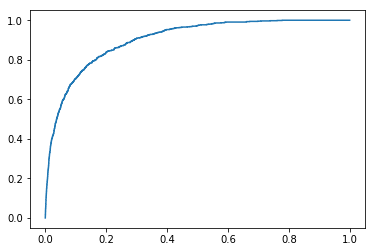

In [20]:
plt.plot(fpr, tpr)

In [21]:
print('outlier:', y_va.outlier.sum(), '\nnot outlier:', y_va.shape[0] - y_va.outlier.sum())

outlier: 869 
not outlier: 75860


In [22]:
for i in range(len(fpr)):
    real_outlier = int(tpr[i]*1351)
    not_outlier = int(fpr[i]*122272)
    total = real_outlier + not_outlier
    print(f'top {total}:  \toutlier {real_outlier} \t not outlier {not_outlier}')

top 0:  	outlier 0 	 not outlier 0
top 1:  	outlier 1 	 not outlier 0
top 5:  	outlier 1 	 not outlier 4
top 8:  	outlier 4 	 not outlier 4
top 10:  	outlier 4 	 not outlier 6
top 12:  	outlier 6 	 not outlier 6
top 14:  	outlier 6 	 not outlier 8
top 17:  	outlier 9 	 not outlier 8
top 18:  	outlier 9 	 not outlier 9
top 19:  	outlier 10 	 not outlier 9
top 26:  	outlier 10 	 not outlier 16
top 28:  	outlier 12 	 not outlier 16
top 29:  	outlier 12 	 not outlier 17
top 30:  	outlier 13 	 not outlier 17
top 35:  	outlier 13 	 not outlier 22
top 42:  	outlier 20 	 not outlier 22
top 63:  	outlier 20 	 not outlier 43
top 64:  	outlier 21 	 not outlier 43
top 72:  	outlier 21 	 not outlier 51
top 77:  	outlier 26 	 not outlier 51
top 80:  	outlier 26 	 not outlier 54
top 81:  	outlier 27 	 not outlier 54
top 83:  	outlier 27 	 not outlier 56
top 87:  	outlier 31 	 not outlier 56
top 89:  	outlier 31 	 not outlier 58
top 93:  	outlier 35 	 not outlier 58
top 105:  	outlier 35 	 not outlier

In [23]:
y_va_sort = y_va.copy()
y_va_sort['pred_prob'] = prob
y_va_sort = y_va_sort.sort_values('pred_prob', ascending=False)

In [24]:
y_va_sort.head()

,outlier,target,pred_prob
25347,1,-33.219281,0.859505
116144,0,-1.170125,0.840169
94554,0,-1.425834,0.839344
56803,0,2.033892,0.837220
42753,1,-33.219281,0.836045


In [25]:
y_va_sort.pred_prob.mean()

0.06602833315775794

In [26]:
outlier.mean()

0.010930233709890698

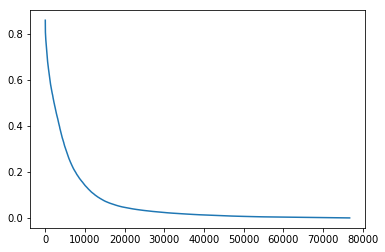

In [27]:
plt.plot(y_va_sort.pred_prob.values)

### regression

In [28]:
rg_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
}

In [29]:
tr_data = lgb.Dataset(X_tr, label=y_tr.target)

In [30]:
cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's rmse: 3.6529 + 0.120686
[400]	cv_agg's rmse: 3.63521 + 0.118588
[600]	cv_agg's rmse: 3.6291 + 0.118203
[800]	cv_agg's rmse: 3.62684 + 0.118228
[1000]	cv_agg's rmse: 3.62651 + 0.118356
[1200]	cv_agg's rmse: 3.62603 + 0.11884
[1400]	cv_agg's rmse: 3.62662 + 0.118514
[1600]	cv_agg's rmse: 3.62699 + 0.118977


In [31]:
print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])

best num:  1149 
best score: 3.625740361079412


In [32]:
clf = lgb.train(rg_param, tr_data, 2000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 3.4864
[400]	training's rmse: 3.36918
[600]	training's rmse: 3.28943
[800]	training's rmse: 3.22785
[1000]	training's rmse: 3.17405
[1200]	training's rmse: 3.12344
[1400]	training's rmse: 3.07776
[1600]	training's rmse: 3.03531
[1800]	training's rmse: 2.99583
[2000]	training's rmse: 2.95647


In [33]:
clf.best_iteration

0

In [34]:
pred = clf.predict(X_va, num_iteration=clf.best_iteration)

In [35]:
get_lb(pred)

3.7026626002538454

In [36]:
y_va_sort.head()

,outlier,target,pred_prob
25347,1,-33.219281,0.859505
116144,0,-1.170125,0.840169
94554,0,-1.425834,0.839344
56803,0,2.033892,0.837220
42753,1,-33.219281,0.836045


#### let's see top20/50 stratory

In [37]:
pred_df = y_va.copy()
pred_df['pred_target'] = pred

In [38]:
pred_df['pred_prob'] = prob

In [39]:

index_20=pred_df.sort_values('pred_prob', ascending=False).head(20).index
index_20

Int64Index([ 25347, 116144,  94554,  56803,  42753,  12602,  51267, 135378,
             15933, 175726,  83942, 120610, 128262,  92357, 155132,   7071,
             82035, 148428, 102057, 159259],
           dtype='int64')

In [40]:
index_20

Int64Index([ 25347, 116144,  94554,  56803,  42753,  12602,  51267, 135378,
             15933, 175726,  83942, 120610, 128262,  92357, 155132,   7071,
             82035, 148428, 102057, 159259],
           dtype='int64')

In [41]:
pred_df.loc[pred_df.index.isin(index_20),'pred_target']=-33.21928095


In [42]:
pred_df.sort_values('pred_prob', ascending=False).head(20)

,outlier,target,pred_target,pred_prob
25347,1,-33.219281,-33.219281,0.859505
116144,0,-1.170125,-33.219281,0.840169
94554,0,-1.425834,-33.219281,0.839344
56803,0,2.033892,-33.219281,0.837220
42753,1,-33.219281,-33.219281,0.836045
12602,1,-33.219281,-33.219281,0.833862
51267,0,-1.420850,-33.219281,0.832792
135378,1,-33.219281,-33.219281,0.831966
15933,0,0.204692,-33.219281,0.831036
175726,1,-33.219281,-33.219281,0.827946


In [43]:
# Predicted test score
get_lb(pred_df.pred_target.values)

3.7147380551655145

### This discrepancy for our original set might be due to mainly.Two reasons: 1) We have  smaller number of outliers in test set than in real test set. 2 ) our prediction is not so accurate


In [44]:
test.shape[0]/y_va.shape[0]

1.6111639666879538

In [45]:
# so our threshould should be arround 16. Let's check it
pred_df = y_va.copy()
pred_df['pred_target'] = pred
pred_df['pred_prob'] = prob
index_16=pred_df.sort_values('pred_prob', ascending=False).head(16).index
pred_df.loc[pred_df.index.isin(index_16),'pred_target']=-33.21928095
get_lb(pred_df.pred_target.values)

3.7126880379636393

## Now, let's just try to iterate more for each treshould values and observe results.

Text(0,0.5,'RMSE')

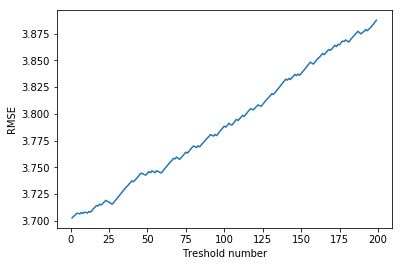

In [46]:
results=[]
pred_df = y_va.copy()
pred_df['pred_target'] = pred
pred_df['pred_prob'] = prob
for i in range(1,200):
    index=pred_df.sort_values('pred_prob', ascending=False).head(i).index
    pred_df.loc[pred_df.index.isin(index),'pred_target']=-33.21928095
    results.append(get_lb(pred_df.pred_target.values))
plt.figure()
plt.plot(range(1,200),results)
plt.xlabel('Treshold number')
plt.ylabel('RMSE')

### We don't see any improvement at all. Probably, our outliers predictions are not so accurate. The reason why we can observe improvement in LB is due to more data for outliers prediction.

## Now, I will try to change our strategy for mixing with and without outliers. Instead of mixing prediction with and without outliers , I will separate dataset to two part so that together they will give best performance.

In [47]:
# We will start by using outliers predictions
pred_df = y_va.copy()
pred_df['pred_target'] = pred
pred_df['pred_prob'] = prob

In [48]:
train.shape

(201917, 257)

In [49]:
cl_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
         "scale_pos_weight": 15,
}

In [50]:
tr_data = lgb.Dataset(X_tr, label=y_tr.outlier)

In [51]:
cv_score = lgb.cv(cl_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=100)

[100]	cv_agg's auc: 0.902398 + 0.00697561
[200]	cv_agg's auc: 0.903697 + 0.00662913
[300]	cv_agg's auc: 0.903734 + 0.00670821
[400]	cv_agg's auc: 0.903137 + 0.00668533
[500]	cv_agg's auc: 0.902398 + 0.00650716
[600]	cv_agg's auc: 0.901779 + 0.00654513
[700]	cv_agg's auc: 0.901337 + 0.006394
[800]	cv_agg's auc: 0.900654 + 0.00646067


In [52]:
print('best num: ', len(cv_score['auc-mean']), '\nbest score:', cv_score['auc-mean'][-1])

best num:  232 
best score: 0.9038768908290219


In [53]:
clf_outlier = lgb.train(cl_param, tr_data, 400, valid_sets=(tr_data), verbose_eval=100)

[100]	training's auc: 0.966905
[200]	training's auc: 0.974608
[300]	training's auc: 0.980398
[400]	training's auc: 0.984885


Original code
[100]	training's auc: 0.966946
[200]	training's auc: 0.974508
[300]	training's auc: 0.980274
[400]	training's auc: 0.984884

In [54]:
clf_outlier.best_iteration


0

In [55]:
prob_train = clf_outlier.predict(X_tr, num_iteration=clf.best_iteration)

In [56]:
y_tr['prob_train']=prob_train

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
## Seems to really good! overfitting
y_tr.sort_values('prob_train',ascending=False).head()

,outlier,target,prob_train
88227,1,-33.219281,0.867037
45032,1,-33.219281,0.857329
100443,1,-33.219281,0.853597
13101,1,-33.219281,0.850782
22187,1,-33.219281,0.848931


In [58]:
y_tr.outlier.sum()

1338

Text(0.5,1,'Test set')

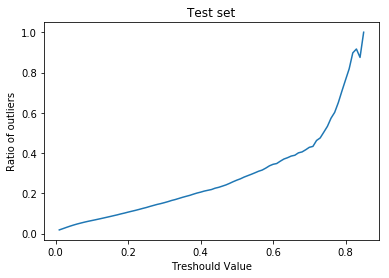

In [59]:
prob_outlier=[]
for i in range(1,86):
    i=i*0.01
    prob_outlier.append(y_tr[y_tr.prob_train>i].outlier.sum()/y_tr[y_tr.prob_train>i].shape[0])
plt.figure()
plt.plot([i*0.01 for i in range(1,86)],prob_outlier)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of outliers")
plt.title("Test set")

In [60]:
pred_df.head()

,outlier,target,pred_target,pred_prob
123115,0,-0.638506,-0.548086,0.002294
87051,0,0.084343,-0.077139,0.032504
122987,0,2.318157,0.425544,0.181516
188373,0,0.338946,-1.383379,0.049641
2165,0,0.537236,-0.251507,0.006939


In [61]:
int(round(pred_df.pred_prob.max()*100+1))

87

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


Text(0.5,1,'Test set')

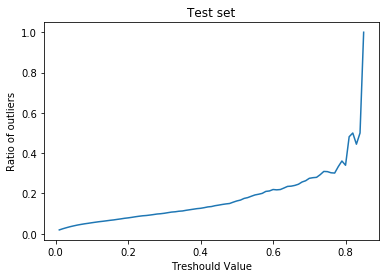

In [62]:
prob_outlier=[]
for i in range(1,int(round(pred_df.pred_prob.max()*100+1))):
    i=i*0.01
    prob_outlier.append(pred_df[pred_df.pred_prob>i].outlier.sum()/pred_df[pred_df.pred_prob>i].shape[0])
plt.figure()
plt.plot([i*0.01 for i in range(1,int(round(pred_df.pred_prob.max()*100+1)))],prob_outlier)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of outliers")
plt.title("Test set")

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


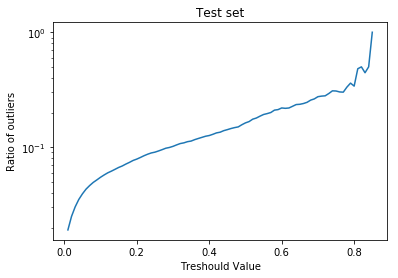

In [63]:
plt.figure()
plt.plot([i*0.01 for i in range(1,int(round(pred_df.pred_prob.max()*100+1)))],prob_outlier)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of outliers")
plt.title("Test set")
plt.yscale('log')

Text(0.5,1,'Test set')

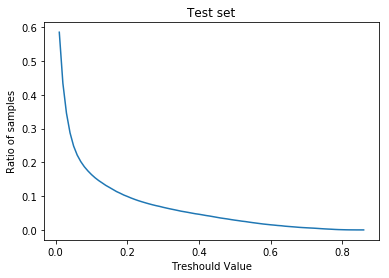

In [64]:
num=[]
for i in range(1,int(round(pred_df.pred_prob.max()*100+1))):
    i=i*0.01
    num.append(pred_df[pred_df.pred_prob>i].shape[0]/pred_df.shape[0])
plt.figure()
plt.plot([i*0.01 for i in range(1,int(round(pred_df.pred_prob.max()*100+1)))],num)
plt.xlabel("Treshould Value")
plt.ylabel("Ratio of samples")
plt.title("Test set")

In [65]:
pred_df[pred_df.pred_prob>0.1].outlier.sum()

689

In [66]:
pred_df[pred_df.pred_prob<0.1].outlier.sum()

180

In [67]:
y_tr[y_tr.prob_train>0.01].outlier.sum()

1338

In [68]:
y_tr[y_tr.prob_train<0.01].outlier.sum()

0

In [69]:
# number of training examples
y_tr[y_tr.prob_train>0.01].shape[0],y_tr[y_tr.prob_train<0.01].shape[0]

(73465, 51723)

In [70]:
# number of test examples
pred_df[pred_df.pred_prob>0.1].shape[0],pred_df[pred_df.pred_prob<0.1].shape[0]

(12571, 64158)

### I have some random idea! Let's try it. We know that outlier is equial -10log(10). So, probably, it features are incoded by this function which is nonlinear. Maybe linear features will give better results.

In [121]:
linear_target=2**(y_tr.target/-10)

In [122]:
rg_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
}

In [123]:
tr_data = lgb.Dataset(X_tr, label=linear_target)

In [124]:
cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's rmse: 0.895244 + 0.0368284
[400]	cv_agg's rmse: 0.893609 + 0.0359247
[600]	cv_agg's rmse: 0.893649 + 0.0357613
[800]	cv_agg's rmse: 0.893875 + 0.0357121
[1000]	cv_agg's rmse: 0.894176 + 0.0358264


In [126]:
print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])

best num:  466 
best score: 0.8935534391583646


In [127]:
clf = lgb.train(rg_param, tr_data, 500, valid_sets=(tr_data), verbose_eval=100)

[100]	training's rmse: 0.871901
[200]	training's rmse: 0.840926
[300]	training's rmse: 0.820992
[400]	training's rmse: 0.807409
[500]	training's rmse: 0.796093


In [128]:
clf.best_iteration

0

In [129]:
pred_log = clf.predict(X_va, num_iteration=clf.best_iteration)
pred_log=-10*np.log2(pred_lin)

In [130]:
# Huge error! It was worst idea Haha
get_lb(pred_log)

5.661605717551893

In [131]:
get_lb(pred_lin)

4.534825533330481

In [132]:
get_lb(pred)

3.7026626002538454

In [139]:
get_lb(np.array([0 for i in range(len(pred_lin))]))


3.9272538581303857

In [92]:
y_va2=y_va.copy()
y_va2['pred_log_target']=pred_log

In [141]:
# Equal to outlier
-10*np.log2(10),y_va2.target.min()

(-33.219280948873624, -33.21928095)

### Another, idea! Let's use outliers predictions as a feature for regression. It work for transperent conductor prediction maybe it can help to improve.

In [147]:
y_tr.prob_train.shape

(125188,)

In [160]:
y_tr.index

Int64Index([140457, 179764,  22899, 160544, 171908, 105318,  25836, 150503,
             50727, 127460,
            ...
            151181, 114565,  81844, 122929, 196886,  61872, 128963,  36482,
             40177, 150781],
           dtype='int64', length=125188)

In [8]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats].values, target_with_outlier, test_size=0.38, random_state=12)

In [9]:
X_tr.shape, X_va.shape, y_tr.shape, y_va.shape

((125188, 253), (76729, 253), (125188, 2), (76729, 2))

In [157]:
train2=train.copy()

In [164]:
train2['prob_outliers']=0

In [166]:
y_tr.head()

,outlier,target,prob_train
140457,0,0.013333,0.320053
179764,0,-0.946788,0.142976
22899,0,-0.301051,0.002098
160544,0,1.036026,0.037259
171908,0,-0.664374,0.018513


In [167]:
# filling prob_outliers for training set
train2.loc[train2.index.isin(y_tr.index),'prob_outliers']=y_tr.prob_train

In [176]:
train2.loc[train2.index.isin(y_va.index),'prob_outliers']=pred_df.pred_prob

In [178]:
feats2=feats[:]
feats2.append('prob_outliers')

In [183]:
X_tr2, X_va2, y_tr2, y_va2 = train_test_split(train2[feats2], target_with_outlier, test_size=0.38, random_state=12)

In [28]:
rg_param = {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 48,
}

In [186]:
tr_data = lgb.Dataset(X_tr2, label=y_tr2.target)

In [187]:
cv_score = lgb.cv(rg_param, tr_data, 10000, early_stopping_rounds=600, verbose_eval=200, stratified=False)

[200]	cv_agg's rmse: 2.94532 + 0.104668
[400]	cv_agg's rmse: 2.84243 + 0.0937743
[600]	cv_agg's rmse: 2.81018 + 0.0920099
[800]	cv_agg's rmse: 2.79241 + 0.0897408
[1000]	cv_agg's rmse: 2.78168 + 0.0901444
[1200]	cv_agg's rmse: 2.77516 + 0.0903369
[1400]	cv_agg's rmse: 2.7693 + 0.0909188
[1600]	cv_agg's rmse: 2.76438 + 0.0908424
[1800]	cv_agg's rmse: 2.76036 + 0.090435
[2000]	cv_agg's rmse: 2.75683 + 0.0901886
[2200]	cv_agg's rmse: 2.75392 + 0.0898743
[2400]	cv_agg's rmse: 2.75158 + 0.0896558
[2600]	cv_agg's rmse: 2.74916 + 0.0888359
[2800]	cv_agg's rmse: 2.74747 + 0.0887952
[3000]	cv_agg's rmse: 2.74619 + 0.0886733
[3200]	cv_agg's rmse: 2.7446 + 0.0883913
[3400]	cv_agg's rmse: 2.74309 + 0.0881613
[3600]	cv_agg's rmse: 2.74221 + 0.0882948
[3800]	cv_agg's rmse: 2.74153 + 0.0885056
[4000]	cv_agg's rmse: 2.74093 + 0.0884648
[4200]	cv_agg's rmse: 2.74016 + 0.0882647
[4400]	cv_agg's rmse: 2.7397 + 0.0881054
[4600]	cv_agg's rmse: 2.73896 + 0.0880526
[4800]	cv_agg's rmse: 2.73819 + 0.0882019
[

In [189]:
print('best num: ', len(cv_score['rmse-mean']), '\nbest score:', cv_score['rmse-mean'][-1])

best num:  9949 
best score: 2.7332440508881763


## This is really amazing! It can be still improved I am worried about overfitting

In [190]:
# Let's try to fit until 10000 and 5000 and compare resutls
clf10 = lgb.train(rg_param, tr_data, 10000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 2.70743
[400]	training's rmse: 2.43657
[600]	training's rmse: 2.29031
[800]	training's rmse: 2.19129
[1000]	training's rmse: 2.11492
[1200]	training's rmse: 2.05255
[1400]	training's rmse: 2.00259
[1600]	training's rmse: 1.95584
[1800]	training's rmse: 1.91521
[2000]	training's rmse: 1.8778
[2200]	training's rmse: 1.84573
[2400]	training's rmse: 1.81538
[2600]	training's rmse: 1.79068
[2800]	training's rmse: 1.76536
[3000]	training's rmse: 1.7436
[3200]	training's rmse: 1.72352
[3400]	training's rmse: 1.70347
[3600]	training's rmse: 1.68511
[3800]	training's rmse: 1.6676
[4000]	training's rmse: 1.64996
[4200]	training's rmse: 1.6339
[4400]	training's rmse: 1.61922
[4600]	training's rmse: 1.60532
[4800]	training's rmse: 1.59158
[5000]	training's rmse: 1.57752
[5200]	training's rmse: 1.56379
[5400]	training's rmse: 1.55201
[5600]	training's rmse: 1.53979
[5800]	training's rmse: 1.52849
[6000]	training's rmse: 1.51667
[6200]	training's rmse: 1.50534
[6400]	training'

In [191]:
clf5 = lgb.train(rg_param, tr_data, 5000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 2.70743
[400]	training's rmse: 2.43657
[600]	training's rmse: 2.29031
[800]	training's rmse: 2.19129
[1000]	training's rmse: 2.11492
[1200]	training's rmse: 2.05255
[1400]	training's rmse: 2.00259
[1600]	training's rmse: 1.95584
[1800]	training's rmse: 1.91521
[2000]	training's rmse: 1.8778
[2200]	training's rmse: 1.84573
[2400]	training's rmse: 1.81538
[2600]	training's rmse: 1.79068
[2800]	training's rmse: 1.76536
[3000]	training's rmse: 1.7436
[3200]	training's rmse: 1.72352
[3400]	training's rmse: 1.70347
[3600]	training's rmse: 1.68511
[3800]	training's rmse: 1.6676
[4000]	training's rmse: 1.64996
[4200]	training's rmse: 1.6339
[4400]	training's rmse: 1.61922
[4600]	training's rmse: 1.60532
[4800]	training's rmse: 1.59158
[5000]	training's rmse: 1.57752


In [196]:
clf1 = lgb.train(rg_param, tr_data, 1000, valid_sets=(tr_data), verbose_eval=200)

[200]	training's rmse: 2.70743
[400]	training's rmse: 2.43657
[600]	training's rmse: 2.29031
[800]	training's rmse: 2.19129
[1000]	training's rmse: 2.11492


In [33]:
clf.best_iteration

0

In [192]:
pred10 = clf10.predict(X_va2, num_iteration=clf.best_iteration)

In [194]:
pred5 = clf5.predict(X_va2, num_iteration=clf.best_iteration)

In [197]:
pred1 = clf1.predict(X_va2, num_iteration=clf.best_iteration)

In [198]:
get_lb(pred1)

3.821413304057852

In [195]:
get_lb(pred5)

3.835911155470752

In [193]:
get_lb(pred10)

3.8398787962019543

In [35]:
get_lb(pred2)

3.7026626002538454

### All of the above results are extremely bad since we are overfitting to test set. Instead we need to devide our test set to 

In [201]:
test.shape

(123623, 255)

In [203]:
train2.shape

(201917, 258)

In [11]:
from sklearn.model_selection import StratifiedKFold

In [215]:
train.shape

(201917, 257)

In [12]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats], target_with_outlier, test_size=0.38, random_state=12)

In [13]:
X_va.shape

(76729, 253)

In [14]:
target=y_tr.outlier
# From chau's kernel but Adam's parameters
param =  {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "scale_pos_weight": 15,
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_out = np.zeros(len(X_tr))
predictions_out = np.zeros(len(X_va))
predictions_out_final = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_tr,y_tr['outlier'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_tr.iloc[trn_idx][feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_tr.iloc[val_idx][feats], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_out[val_idx] = clf.predict(X_tr.iloc[val_idx][feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_out += clf.predict(X_va[feats], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_out_final += clf.predict(test[feats], num_iteration=clf.best_iteration) / folds.n_splits


np.sqrt(mean_squared_error(oof_out, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.917183	valid_1's auc: 0.91992
[200]	training's auc: 0.924252	valid_1's auc: 0.921347
[300]	training's auc: 0.929413	valid_1's auc: 0.921534
[400]	training's auc: 0.933795	valid_1's auc: 0.921478
Early stopping, best iteration is:
[355]	training's auc: 0.931838	valid_1's auc: 0.921751
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.918611	valid_1's auc: 0.906582
[200]	training's auc: 0.925213	valid_1's auc: 0.908707
[300]	training's auc: 0.929988	valid_1's auc: 0.910282
[400]	training's auc: 0.934385	valid_1's auc: 0.911197
[500]	training's auc: 0.938165	valid_1's auc: 0.91164
[600]	training's auc: 0.941646	valid_1's auc: 0.91179
[700]	training's auc: 0.944731	valid_1's auc: 0.911839
[800]	training's auc: 0.947757	valid_1's auc: 0.911896
Early stopping, best iteration is:
[723]	training's auc: 0.945501	valid_1's auc: 0.911964
fold 2
Training until v

0.17040935323352144

In [15]:
# Large error
np.sqrt(mean_squared_error(oof_out, target))

0.17040935323352144

### Let's look at relatio of predicted target to predicted outliers

In [16]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats], target_with_outlier, test_size=0.38, random_state=12)

In [17]:
y_tr.head()

,outlier,target
140457,0,0.013333
179764,0,-0.946788
22899,0,-0.301051
160544,0,1.036026
171908,0,-0.664374


In [18]:

target=y_tr.target
# From chau's kernel but Adam's parameters
param =  {
         'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_reg = np.zeros(len(X_tr))
predictions_reg = np.zeros(len(X_va))
predictions_final = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_tr,y_tr['outlier'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_tr.iloc[trn_idx][feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_tr.iloc[val_idx][feats], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_reg[val_idx] = clf.predict(X_tr.iloc[val_idx][feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_reg += clf.predict(X_va[feats], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_final += clf.predict(test[feats], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof_reg, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.58046	valid_1's rmse: 3.66991
[200]	training's rmse: 3.46286	valid_1's rmse: 3.63273
[300]	training's rmse: 3.39054	valid_1's rmse: 3.61732
[400]	training's rmse: 3.33437	valid_1's rmse: 3.61146
[500]	training's rmse: 3.28756	valid_1's rmse: 3.60716
[600]	training's rmse: 3.24652	valid_1's rmse: 3.60529
[700]	training's rmse: 3.20942	valid_1's rmse: 3.60469
[800]	training's rmse: 3.17664	valid_1's rmse: 3.60481
[900]	training's rmse: 3.14277	valid_1's rmse: 3.60478
[1000]	training's rmse: 3.11189	valid_1's rmse: 3.60485
Early stopping, best iteration is:
[933]	training's rmse: 3.1324	valid_1's rmse: 3.60412
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.5773	valid_1's rmse: 3.68439
[200]	training's rmse: 3.45854	valid_1's rmse: 3.65424
[300]	training's rmse: 3.38404	valid_1's rmse: 3.6419
[400]	training's rmse: 3.3258	valid_1's rmse: 3.63482
[50

3.630738758585358

### Amazing we have less error with smaller dataset.
3.649012733482272 before splitting
Now,
3.6329832506410753

In [21]:
y_va['predicted_target']=predictions_reg

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
# Almost similar results for test set
get_lb(y_va.predicted_target.values)

3.7002935017637917

In [23]:
y_tr['predicted_target']=oof_reg
y_va['predicted_target']=predictions_reg
y_tr['prob_out']=oof_out
y_va['prob_out']=predictions_out

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [24]:
y_va_sorted=y_va.sort_values('prob_out',ascending=False)
y_tr_sorted=y_tr.sort_values('prob_out',ascending=False)

In [25]:
y_va_sorted=y_va_sorted[y_va_sorted.prob_out>0.5]
y_tr_sorted=y_tr_sorted[y_tr_sorted.prob_out>0.5]

In [26]:
y_tr_sorted.shape[0],y_va_sorted.shape[0]

(4050, 2495)

In [27]:
ratio_va=[]
number_va=[]
ratio_tr=[]
number_tr=[]
for i in range(0,-25,-1):
    n_va=y_va_sorted[y_va_sorted.predicted_target<i].shape[0]
    number_va.append(n_va)
    ratio_va.append(y_va_sorted[y_va_sorted.predicted_target<i].outlier.sum()/n_va)
    
    n_tr=y_tr_sorted[y_tr_sorted.predicted_target<i].shape[0]
    number_tr.append(n_tr)
    ratio_tr.append(y_tr_sorted[y_tr_sorted.predicted_target<i].outlier.sum()/n_tr)
    

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


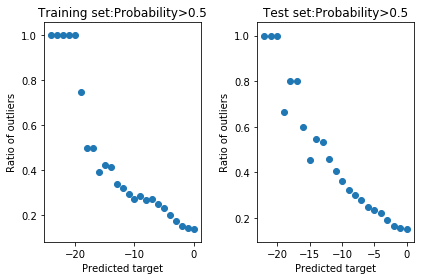

In [28]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(range(0,-25,-1),ratio_tr)
plt.ylabel('Ratio of outliers')
plt.xlabel('Predicted target')
plt.title('Training set:Probability>0.5')
plt.subplot(1,2,2)
plt.scatter(range(0,-25,-1),ratio_va)
plt.ylabel('Ratio of outliers')
plt.xlabel('Predicted target')
plt.title('Test set:Probability>0.5')
plt.tight_layout()
plt.show()

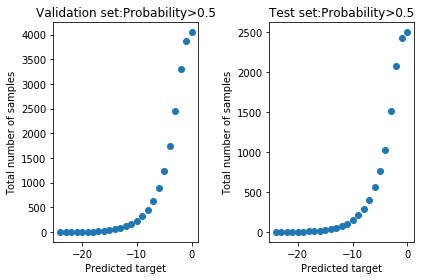

In [29]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(range(0,-25,-1),number_tr)
plt.ylabel('Total number of samples')
plt.xlabel('Predicted target')
plt.title('Validation set:Probability>0.5')
plt.subplot(1,2,2)
plt.scatter(range(0,-25,-1),number_va)
plt.ylabel('Total number of samples')
plt.xlabel('Predicted target')
plt.title('Test set:Probability>0.5')
plt.tight_layout()



In [30]:
y_tr.loc[:,['predicted_target','prob_out']].head()

,predicted_target,prob_out
140457,-2.384720,0.417188
179764,-1.318909,0.240523
22899,0.133268,0.007925
160544,0.827795,0.054423
171908,-0.150823,0.026663


In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
reg = LinearRegression().fit(y_tr.loc[:,['predicted_target','prob_out']],y_tr.loc[:,'target'])
print(reg.score(y_tr.loc[:,['predicted_target','prob_out']],y_tr.loc[:,'target']))
reg_pred=reg.predict(y_va.loc[:,['predicted_target','prob_out']])
get_lb(reg_pred)
#Almost no improvement haha


0.09521932410967981


3.7000553656609774

In [35]:
reg_score=[]
test_score=[]
for num in range(1,1000):
    reg = LinearRegression().fit(y_tr_sorted.loc[:,['predicted_target','prob_out']].head(num),y_tr_sorted.loc[:,'target'].head(num))
    reg_score.append(reg.score(y_tr_sorted.loc[:,['predicted_target','prob_out']].head(num),y_tr_sorted.loc[:,'target'].head(num)))
    pred=reg.predict(y_va_sorted.loc[:,['predicted_target','prob_out']].head(num))
    target=y_va.predicted_target.copy()
    target.loc[target.index.isin(y_va_sorted.head(num).index)]=pred
    test_score.append(get_lb(target))
    

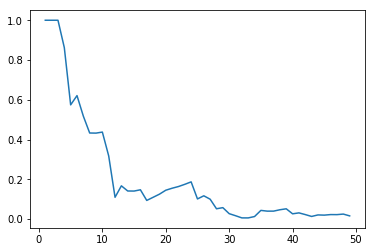

In [36]:
plt.figure()
plt.plot(range(1,50),reg_score[0:49])

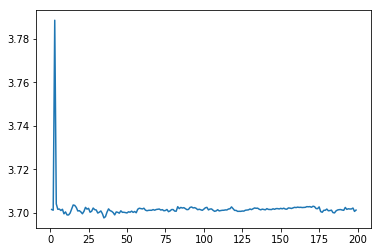

In [37]:
plt.figure()
plt.plot(range(1,200),test_score[:199])

In [39]:
target=y_va.target.copy()

In [40]:
target.loc[target.index.isin(y_va_sorted.head(20).index)]=-30

In [41]:
get_lb(y_va.predicted_target.values)

3.7002935017637917

In [ ]:
import random

In [ ]:
a=[]
for i in range(1000):
    a+=random.choices([0,1],weights=[0.9,0.1])

In [12]:
X_tr, X_va, y_tr, y_va = train_test_split(train[feats], target_with_outlier, test_size=0.38, random_state=12)

In [13]:
X_va.shape

(76729, 253)

In [49]:
target=y_tr.outlier
# From chau's kernel but Adam's parameters
param =  {
         'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9, #
         "bagging_freq": 1,
         "bagging_fraction": 0.9, #
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "scale_pos_weight": 15,
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_out_proba = np.zeros(len(X_tr))
predictions_out_proba = np.zeros(len(X_va))
predictions_out_final_proba = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_tr,y_tr['outlier'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_tr.iloc[trn_idx][feats], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X_tr.iloc[val_idx][feats], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_out_proba[val_idx] = clf.predict(X_tr.iloc[val_idx][feats], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_out_proba += clf.predict(X_va[feats], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_out_final_proba += clf.predict(test[feats], num_iteration=clf.best_iteration) / folds.n_splits


#np.sqrt(mean_squared_error(oof_out, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0671082	valid_1's binary_logloss: 0.0720479
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0484886	valid_1's binary_logloss: 0.0502096
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0664381	valid_1's binary_logloss: 0.0720133
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0483025	valid_1's binary_logloss: 0.0507281
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0655342	valid_1's binary_logloss: 0.0750983
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0481346	valid_1's binary_logloss: 0.0516465
fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0656604	valid_1's binary_logloss: 0.074284
Early stopping, best iteration is:
[11]	training's binary_logloss:

In [52]:
y_tr['pred_proba']=oof_out_proba
y_va['pred_proba']=predictions_out_proba

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
y_va.sort_values('pred_proba',ascending=False)

,outlier,target,predicted_target,prob_out,pred_proba
121556,0,-0.330013,-15.395987,0.815893,0.104791
59156,0,-3.076884,-13.947709,0.785804,0.104791
145192,0,0.381281,-7.360986,0.676012,0.104727
139384,1,-33.219281,-14.083611,0.826792,0.104485
25347,1,-33.219281,-22.582171,0.850167,0.104402
94554,0,-1.425834,-19.563889,0.855501,0.104316
68825,0,-0.553302,-12.175527,0.807013,0.103644
151711,0,-0.399803,-10.127872,0.795408,0.103634
179088,1,-33.219281,-12.416098,0.812498,0.103634
63172,0,1.455046,-12.974710,0.817353,0.103634


In [ ]:
random.choices(population, weights=None, *, cum_weights=None, k=1)¶
